# Presentation figures

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import xarray as xr
import dedalus.public as d3

from modules import regridding, models

## Method flowchart thumbnails

In [21]:
fine_t = xr.open_mfdataset(
    '../data/training/2048x256_t/*.nc'
).theta
fine_tplusdt = xr.open_mfdataset(
    '../data/training/2048x256_tplusdt/*.nc'
).theta
fine_tend_filt = xr.open_dataset(
    '../data/training/2048x256_tend_256x32/2048x256_tend_256x32.nc'
).theta
coarse_t = xr.open_mfdataset(
    '../data/training/256x32_from_2048x256_diffused_t/*.nc'
).theta
coarse_tplusdt = xr.open_mfdataset(
    '../data/training/256x32_from_2048x256_diffused_tplusdt/*.nc'
).theta

fine_t = fine_t.isel(t=(fine_t.t < 299))
fine_tplusdt = fine_tplusdt.isel(t=(fine_tplusdt.t < 299))
coarse_t = coarse_t.isel(t=(coarse_t.t < 299))
coarse_tplusdt = coarse_tplusdt.isel(t=(coarse_tplusdt.t < 299))

In [22]:
def tendency(state_t, state_tplusdt):
    tend = (state_tplusdt.drop('t') - state_t.drop('t'))/state_t.timestep
    return tend.assign_coords({'t': state_t.t})

fine_tend = tendency(fine_t, fine_tplusdt)
coarse_tend = tendency(coarse_t, coarse_tplusdt)
subgrid_tend = fine_tend_filt - coarse_tend

In [62]:
def plot(data, vmin, vmax, path):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.pcolormesh(data.x, data.z, data.T, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set(xlim=(0, 2), aspect='equal')
    fig.tight_layout()
    fig.savefig(path, bbox_inches='tight', dpi=100)

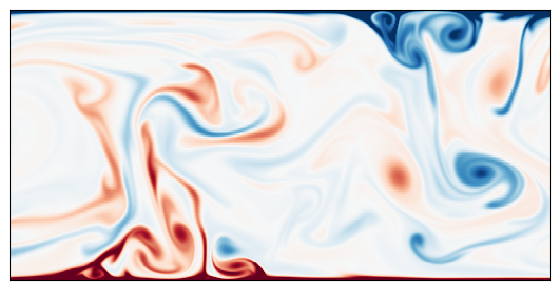

In [63]:
plot(fine_t.isel(t=-2), vmin=-0.2, vmax=0.2, path='../figures/update1/fine_t.png')

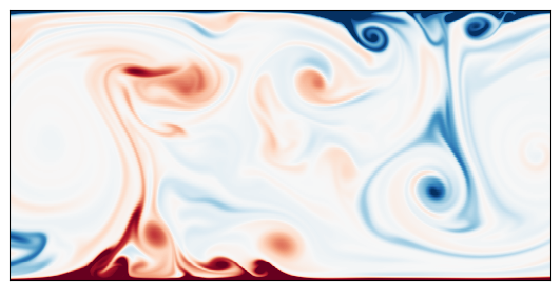

In [64]:
plot(fine_t.isel(t=-1), vmin=-0.2, vmax=0.2, path='../figures/update1/fine_tplusdt.png')

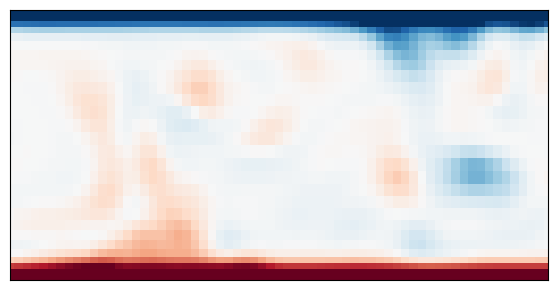

In [65]:
plot(coarse_t.isel(t=-2), vmin=-0.2, vmax=0.2, path='../figures/update1/coarse_t.png')

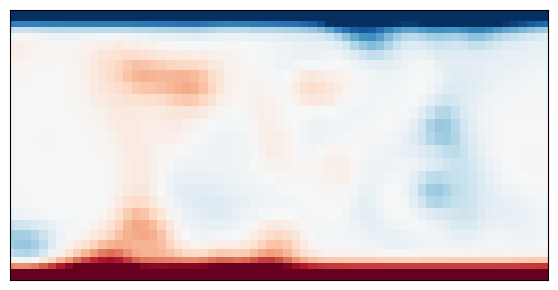

In [66]:
plot(coarse_t.isel(t=-1), vmin=-0.2, vmax=0.2, path='../figures/update1/coarse_tplusdt.png')

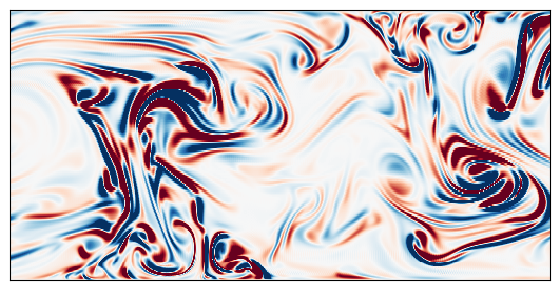

In [71]:
plot(fine_tend.isel(t=-2), vmin=-0.5, vmax=0.5, path='../figures/update1/fine_tend.png')

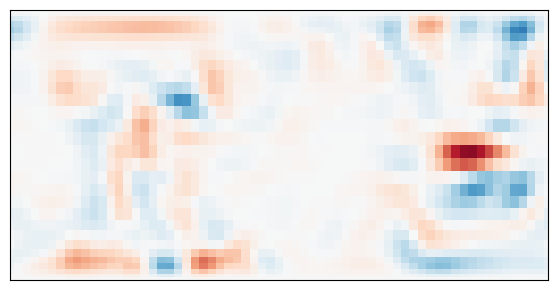

In [72]:
plot(coarse_tend.isel(t=-2), vmin=-0.5, vmax=0.5, path='../figures/update1/coarse_tend.png')

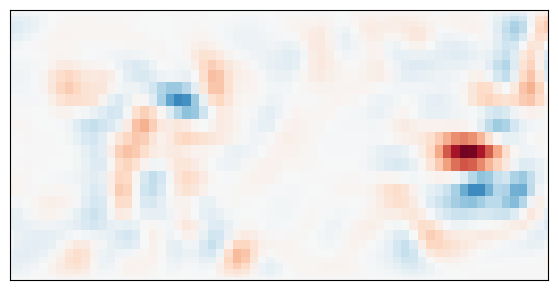

In [73]:
plot(fine_tend_filt.isel(t=-2), vmin=-0.5, vmax=0.5, path='../figures/update1/fine_tend_filt.png')

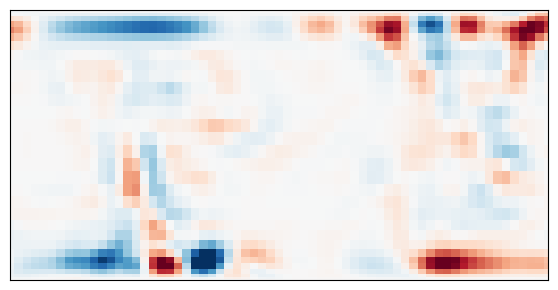

In [75]:
plot(subgrid_tend.isel(t=-2), vmin=-0.2, vmax=0.2, path='../figures/update1/subgrid_tend.png')

## Original coarse-graining method

In [77]:
regridder = regridding.Regridder(
    source=fine_t, target=coarse_t,
    limits={'z': (0, 1)}, periods={'x': 8}
)
coarse_t_regrid = regridder(fine_t.isel(t=-1))

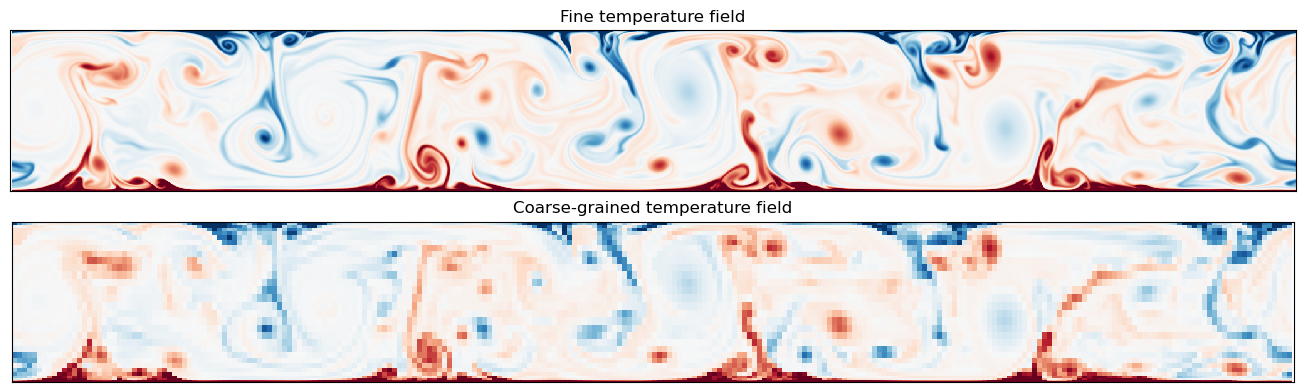

In [81]:
fig, axes = plt.subplots(2, 1, figsize=(14,4), sharex=True)

axes[0].pcolormesh(
    fine_t.x, fine_t.z, fine_t.isel(t=-1).T, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
axes[0].set(aspect='equal', title='Fine temperature field')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

axes[1].pcolormesh(
    coarse_t.x, coarse_t.z, coarse_t_regrid, cmap='RdBu_r', vmin=-0.2, vmax=0.2)
axes[1].set(aspect='equal', title='Coarse-grained temperature field')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

fig.tight_layout()
fig.savefig('../figures/update1/old_coarse_grain.png', dpi=100, bbox_inches='tight')

## New coarse-graining method

In [83]:
model = models.DiffusionModel(8, 2048, 256)

2023-09-28 04:53:42,937 subsystems 0/1 INFO :: Building subproblem matrices 1/1024 (~0%) Elapsed: 1s, Remaining: 8m 35s, Rate: 2.0e+00/s
2023-09-28 04:53:52,721 subsystems 0/1 INFO :: Building subproblem matrices 101/1024 (~10%) Elapsed: 10s, Remaining: 1m 34s, Rate: 9.8e+00/s
2023-09-28 04:53:52,913 subsystems 0/1 INFO :: Building subproblem matrices 103/1024 (~10%) Elapsed: 10s, Remaining: 1m 34s, Rate: 9.8e+00/s
2023-09-28 04:54:02,487 subsystems 0/1 INFO :: Building subproblem matrices 203/1024 (~20%) Elapsed: 20s, Remaining: 1m 21s, Rate: 1.0e+01/s
2023-09-28 04:54:02,775 subsystems 0/1 INFO :: Building subproblem matrices 206/1024 (~20%) Elapsed: 20s, Remaining: 1m 21s, Rate: 1.0e+01/s
2023-09-28 04:54:12,445 subsystems 0/1 INFO :: Building subproblem matrices 305/1024 (~30%) Elapsed: 30s, Remaining: 1m 11s, Rate: 1.0e+01/s
2023-09-28 04:54:12,829 subsystems 0/1 INFO :: Building subproblem matrices 309/1024 (~30%) Elapsed: 30s, Remaining: 1m 10s, Rate: 1.0e+01/s
2023-09-28 04:54:

In [89]:
data = xr.open_mfdataset('../data/training/2048x256_t/*.nc').isel(t=-2)
u = data.u.data.compute()
w = data.w.data.compute()
theta = data.theta.data.compute()
x = data.x.data
z = data.z.data

In [90]:
u_smooth, w_smooth, theta_smooth = model.run(u, w, theta, time=1e-3, dt=2e-4, to_shape=(256, 32))

In [91]:
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=256, bounds=(0, 8))
zbasis = d3.ChebyshevT(coords['z'], size=32, bounds=(0, 1))
x_smooth = dist.local_grid(xbasis).squeeze()
z_smooth = dist.local_grid(zbasis).squeeze()

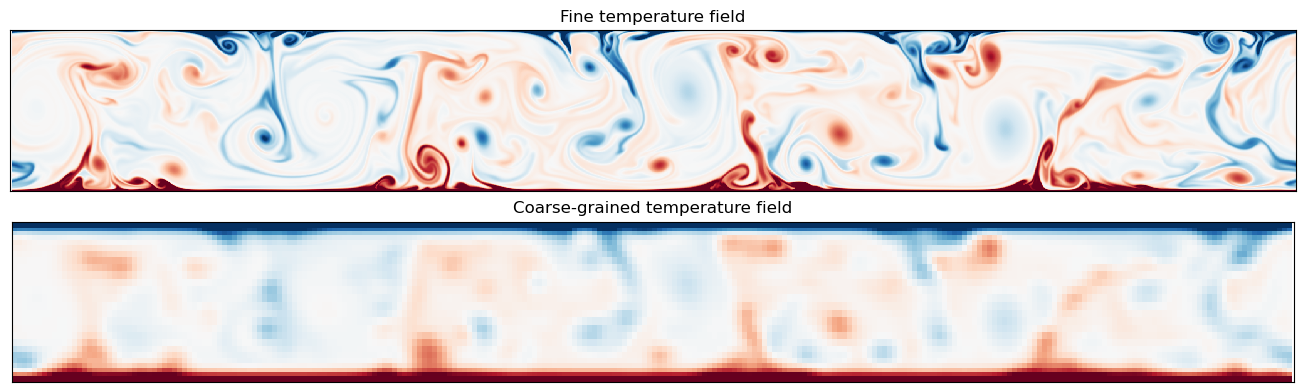

In [92]:
fig, axes = plt.subplots(2, 1, figsize=(14, 4), sharex=True)
clim = 0.2

axes[0].pcolormesh(x, z, theta.T, cmap='RdBu_r', vmin=-clim, vmax=clim)
axes[0].set(aspect='equal', title='Fine temperature field')
axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)

axes[1].pcolormesh(x_smooth, z_smooth, theta_smooth.T, cmap='RdBu_r', vmin=-clim, vmax=clim)
axes[1].set(aspect='equal', title='Coarse-grained temperature field')
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

fig.tight_layout()
fig.savefig('../figures/update1/new_coarse_grain.png', dpi=100, bbox_inches='tight')

## Histograms

In [2]:
fine_t = xr.open_mfdataset('../data/training/2048x256_t/*.nc')
fine_tplusdt = xr.open_mfdataset('../data/training/2048x256_tplusdt/*.nc')
fine_tend_filt = xr.open_dataset(
    '../data/training/2048x256_tend_256x32/2048x256_tend_256x32.nc')
coarse_t = xr.open_mfdataset(
    '../data/training/256x32_from_2048x256_diffused_t/*.nc')
coarse_tplusdt = xr.open_mfdataset(
    '../data/training/256x32_from_2048x256_diffused_tplusdt/*.nc')

fine_t = fine_t.isel(t=(fine_t.t < 299))
fine_tplusdt = fine_tplusdt.isel(t=(fine_tplusdt.t < 299))
coarse_t = coarse_t.isel(t=(coarse_t.t < 299))
coarse_tplusdt = coarse_tplusdt.isel(t=(coarse_tplusdt.t < 299))

In [3]:
def tendency(state_t, state_tplusdt):
    tend = (state_tplusdt.drop('t') - state_t.drop('t'))/state_t.timestep
    return tend.assign_coords({'t': state_t.t})

fine_tend = tendency(fine_t, fine_tplusdt)
coarse_tend = tendency(coarse_t, coarse_tplusdt)
subgrid_tend = fine_tend_filt - coarse_tend

In [4]:
rng = np.random.default_rng(seed=0)
x_sample = rng.uniform(0, 8, 256*32)
z_sample = rng.uniform(0, 1, 256*32)

In [5]:
def insert_bc(data, bottom, top, aspect=8):
    """
    Inserts the boundary conditions into a DataArray.

    Args:
        data: xr.DataArray.
        bottom: z=0 boundary condition.
        top: z=1 boundary condition.
        aspect: Domain aspect ratio.

    Returns:
        xr.DataArray with z=0,1 and periodic x boundary values inserted.
    """
    
    z_bc = xr.DataArray([bottom], coords={'z': [0.]})
    _, z_bc = xr.broadcast(subgrid_tend.isel(z=0), z_bc)
    data = xr.concat([z_bc, data], dim='z')

    z_bc = xr.DataArray([top], coords={'z': [1.]})
    _, z_bc = xr.broadcast(subgrid_tend.isel(z=0), z_bc)
    data = xr.concat([data, z_bc], dim='z')

    x_bc = data.sel(x=0).assign_coords({'x': aspect})
    data = xr.concat([data, x_bc], dim='x')
    return data


def uniform_sample(data, x, z, bottom, top, aspect=8):
    data = insert_bc(data, bottom, top, aspect)
    return sp.interpolate.interpn(
        (data.x.data, data.z.data), data.transpose('x', 'z', 't').data,
        np.stack([x, z], axis=1),
    ).ravel()

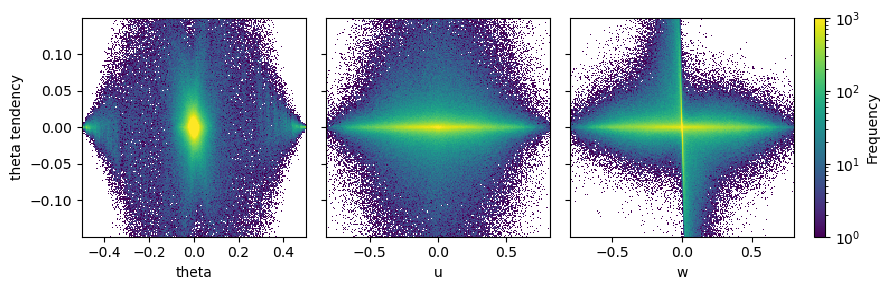

In [26]:
fig = plt.figure(figsize=(9, 3))
gs = mpl.gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], hspace=0)
hist2d_nbins = 200
n_std = 3
tend_var = 'theta'

tend_data = uniform_sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, state_var in enumerate(coarse_t.data_vars):
    state_data = uniform_sample(
        coarse_t[state_var].compute(), x_sample, z_sample,
        1/2 if state_var == 'theta' else 0,
        -1/2 if state_var == 'theta' else 0,
    )
    if state_var == 'theta':
        state_lim = 0.5
    else:
        state_lim = n_std*state_data.std()

    ax = fig.add_subplot(gs[i])
    _, _, _, hist = ax.hist2d(
        state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
        range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
        norm='log', vmin=1, vmax=1e3
    )
    ax.set_xlabel(state_var)
    ax.set_ylim(-tend_lim, tend_lim)
    if i == 0:
        ax.set_ylabel(f'{tend_var} tendency')
    else:
        ax.set_yticklabels([])

ax = fig.add_subplot(gs[-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout(w_pad=0)
fig.savefig(f'../figures/update1/{tend_var}_tend.png', dpi=200, bbox_inches='tight')

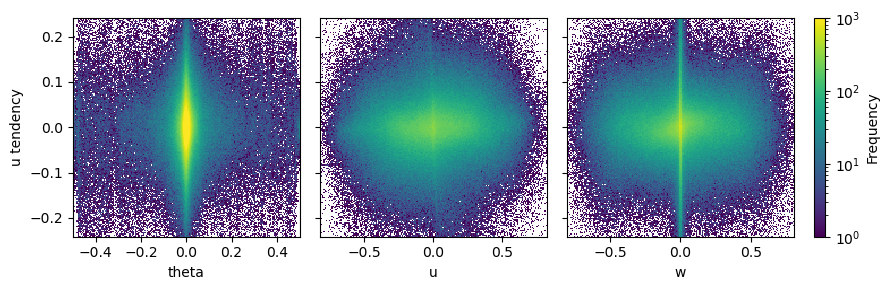

In [27]:
fig = plt.figure(figsize=(9, 3))
gs = mpl.gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], hspace=0)
hist2d_nbins = 200
n_std = 3
tend_var = 'u'

tend_data = uniform_sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, state_var in enumerate(coarse_t.data_vars):
    state_data = uniform_sample(
        coarse_t[state_var].compute(), x_sample, z_sample,
        1/2 if state_var == 'theta' else 0,
        -1/2 if state_var == 'theta' else 0,
    )
    if state_var == 'theta':
        state_lim = 0.5
    else:
        state_lim = n_std*state_data.std()

    ax = fig.add_subplot(gs[i])
    _, _, _, hist = ax.hist2d(
        state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
        range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
        norm='log', vmin=1, vmax=1e3
    )
    ax.set_xlabel(state_var)
    ax.set_ylim(-tend_lim, tend_lim)
    if i == 0:
        ax.set_ylabel(f'{tend_var} tendency')
    else:
        ax.set_yticklabels([])

ax = fig.add_subplot(gs[-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout(w_pad=0)
fig.savefig(f'../figures/update1/{tend_var}_tend.png', dpi=200, bbox_inches='tight')

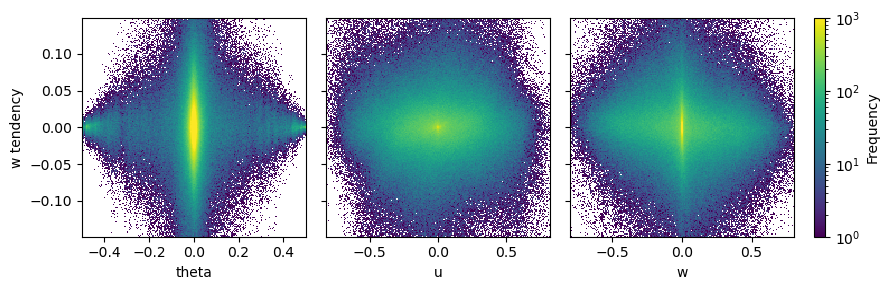

In [28]:
fig = plt.figure(figsize=(9, 3))
gs = mpl.gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05], hspace=0)
hist2d_nbins = 200
n_std = 3
tend_var = 'w'

tend_data = uniform_sample(
    subgrid_tend[tend_var].compute(), x_sample, z_sample, 0, 0)
tend_lim = n_std*tend_data.std()

for i, state_var in enumerate(coarse_t.data_vars):
    state_data = uniform_sample(
        coarse_t[state_var].compute(), x_sample, z_sample,
        1/2 if state_var == 'theta' else 0,
        -1/2 if state_var == 'theta' else 0,
    )
    if state_var == 'theta':
        state_lim = 0.5
    else:
        state_lim = n_std*state_data.std()

    ax = fig.add_subplot(gs[i])
    _, _, _, hist = ax.hist2d(
        state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
        range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
        norm='log', vmin=1, vmax=1e3
    )
    ax.set_xlabel(state_var)
    ax.set_ylim(-tend_lim, tend_lim)
    if i == 0:
        ax.set_ylabel(f'{tend_var} tendency')
    else:
        ax.set_yticklabels([])

ax = fig.add_subplot(gs[-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout(w_pad=0)
fig.savefig(f'../figures/update1/{tend_var}_tend.png', dpi=200, bbox_inches='tight')